In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manasviman","key":"30d2c851736eb51212e0c820dc3913d8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0


In [ ]:
import zipfile
with zipfile.ZipFile("fer2013.zip", "r") as zip_ref:
    zip_ref.extractall("fer2013")

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = '/content/fer2013'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels for ResNet
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet stats
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model = models.resnet50(pretrained=True)

# Modify the final FC layer to match number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def train(num_epochs=20):
    train_loss, val_loss = [], []
    train_accuracy, val_accuracy = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss.append(avg_train_loss)
        train_accuracy.append(train_acc)

        # Validation
        model.eval()
        val_running_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(test_loader)
        val_acc = 100 * correct / total
        val_loss.append(avg_val_loss)
        val_accuracy.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_loss, val_loss, train_accuracy, val_accuracy

Epoch [1/20] - Train Loss: 1.1006, Train Acc: 58.53% | Val Loss: 0.9580, Val Acc: 63.90%


Epoch [2/20] - Train Loss: 0.8029, Train Acc: 70.53% | Val Loss: 0.9475, Val Acc: 64.98%


Epoch [3/20] - Train Loss: 0.5638, Train Acc: 79.99% | Val Loss: 1.0319, Val Acc: 64.85%


Epoch [4/20] - Train Loss: 0.3377, Train Acc: 88.18% | Val Loss: 1.1631, Val Acc: 65.59%


Epoch [5/20] - Train Loss: 0.1947, Train Acc: 93.63% | Val Loss: 1.3027, Val Acc: 65.12%


Epoch [6/20] - Train Loss: 0.1424, Train Acc: 95.27% | Val Loss: 1.4599, Val Acc: 64.50%


Epoch [7/20] - Train Loss: 0.1091, Train Acc: 96.49% | Val Loss: 1.6457, Val Acc: 65.49%


Epoch [8/20] - Train Loss: 0.1021, Train Acc: 96.67% | Val Loss: 1.6338, Val Acc: 64.61%


Epoch [9/20] - Train Loss: 0.0926, Train Acc: 97.02% | Val Loss: 1.6086, Val Acc: 65.31%


Epoch [10/20] - Train Loss: 0.0834, Train Acc: 97.26% | Val Loss: 1.7256, Val Acc: 64.50%


Epoch [11/20] - Train Loss: 0.0797, Train Acc: 97.34% | Val Loss: 1.6443, Val Acc: 65.37%


Epoch [12/20] - Train Loss: 0.0684, Train Acc: 97.88% | Val Loss: 1.6688, Val Acc: 65.06%


Epoch [13/20] - Train Loss: 0.0820, Train Acc: 97.15% | Val Loss: 1.6896, Val Acc: 66.65%


Epoch [14/20] - Train Loss: 0.0581, Train Acc: 98.16% | Val Loss: 1.8885, Val Acc: 66.26%


Epoch [15/20] - Train Loss: 0.0586, Train Acc: 98.00% | Val Loss: 1.9303, Val Acc: 64.61%


Epoch [16/20] - Train Loss: 0.0625, Train Acc: 97.88% | Val Loss: 1.8521, Val Acc: 65.71%


Epoch [17/20] - Train Loss: 0.0642, Train Acc: 97.82% | Val Loss: 1.9218, Val Acc: 64.08%


Epoch [18/20] - Train Loss: 0.0660, Train Acc: 97.71% | Val Loss: 1.8399, Val Acc: 65.37%


Epoch [19/20] - Train Loss: 0.0450, Train Acc: 98.46% | Val Loss: 1.8000, Val Acc: 65.38%


Epoch [20/20] - Train Loss: 0.0485, Train Acc: 98.31% | Val Loss: 2.0588, Val Acc: 65.10%


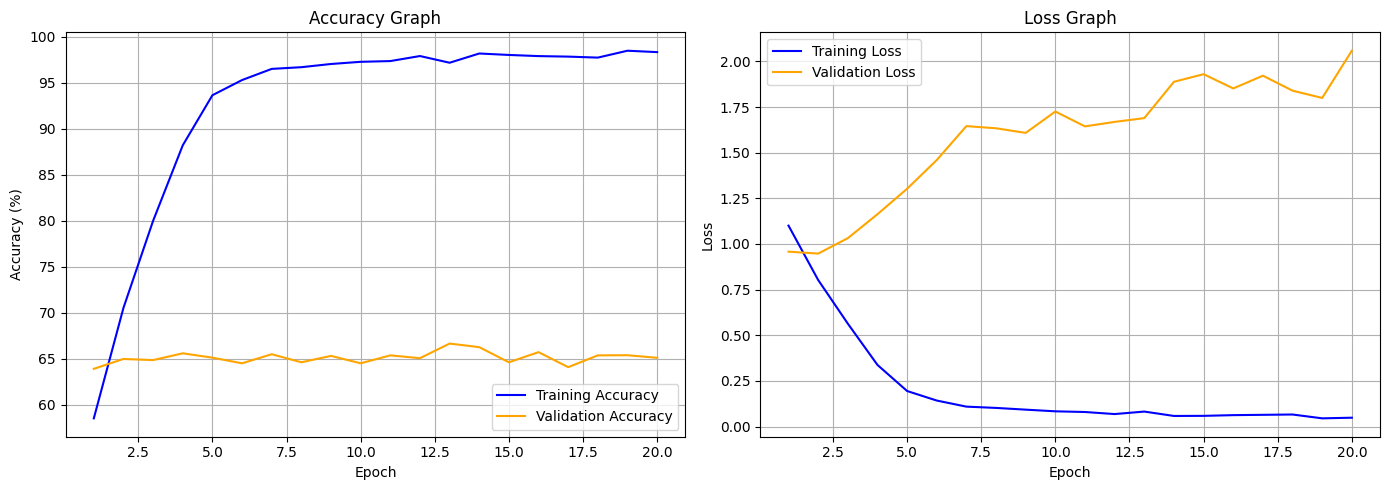

In [ ]:
train_loss, val_loss, train_accuracy, val_accuracy = train(num_epochs=20)

epochs = range(1, 21)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
ax1.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
ax1.set_title('Accuracy Graph')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(epochs, train_loss, label='Training Loss', color='blue')
ax2.plot(epochs, val_loss, label='Validation Loss', color='orange')
ax2.set_title('Loss Graph')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_test_accuracy():
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
print(f"\nFinal Training Accuracy: {train_accuracy[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.2f}%")
evaluate_test_accuracy()


Final Training Accuracy: 98.31%
Final Validation Accuracy: 65.10%
Final Test Accuracy: 65.10%


In [ ]:
def evaluate_classification_report():
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

def plot_confusion_matrix():
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    plt.figure(figsize=(8, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix on Test Set')
    plt.show()


Classification Report:

              precision    recall  f1-score   support

       angry       0.49      0.67      0.57       958
     disgust       0.76      0.50      0.60       111
        fear       0.55      0.44      0.49      1024
       happy       0.87      0.84      0.85      1774
     neutral       0.58      0.65      0.61      1233
         sad       0.57      0.45      0.50      1247
    surprise       0.76      0.80      0.78       831

    accuracy                           0.65      7178
   macro avg       0.65      0.62      0.63      7178
weighted avg       0.66      0.65      0.65      7178



<Figure size 800x800 with 0 Axes>

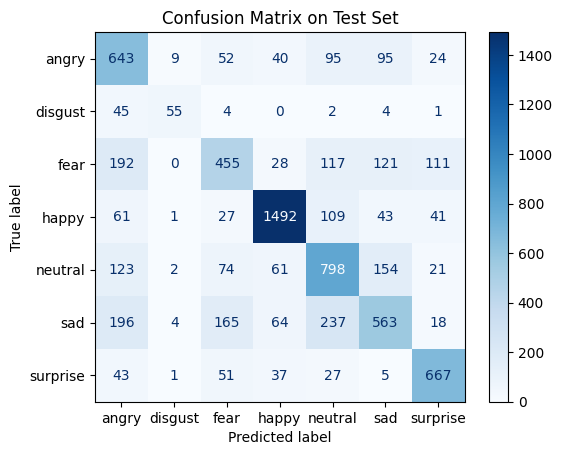

In [ ]:
# Evaluate model on test set and print classification report
evaluate_classification_report()

# Plot confusion matrix
plot_confusion_matrix()

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

def show_predictions(model, test_loader, class_names):
    model.eval()
    data_iter = iter(test_loader)
    images_shown = 0
    plt.figure(figsize=(15, 8))

    while images_shown < 10:
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if images_shown >= 10:
                break
            ax = plt.subplot(2, 5, images_shown + 1)
            imshow(images[i].cpu())
            ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
            images_shown += 1

    plt.tight_layout()
    plt.show()

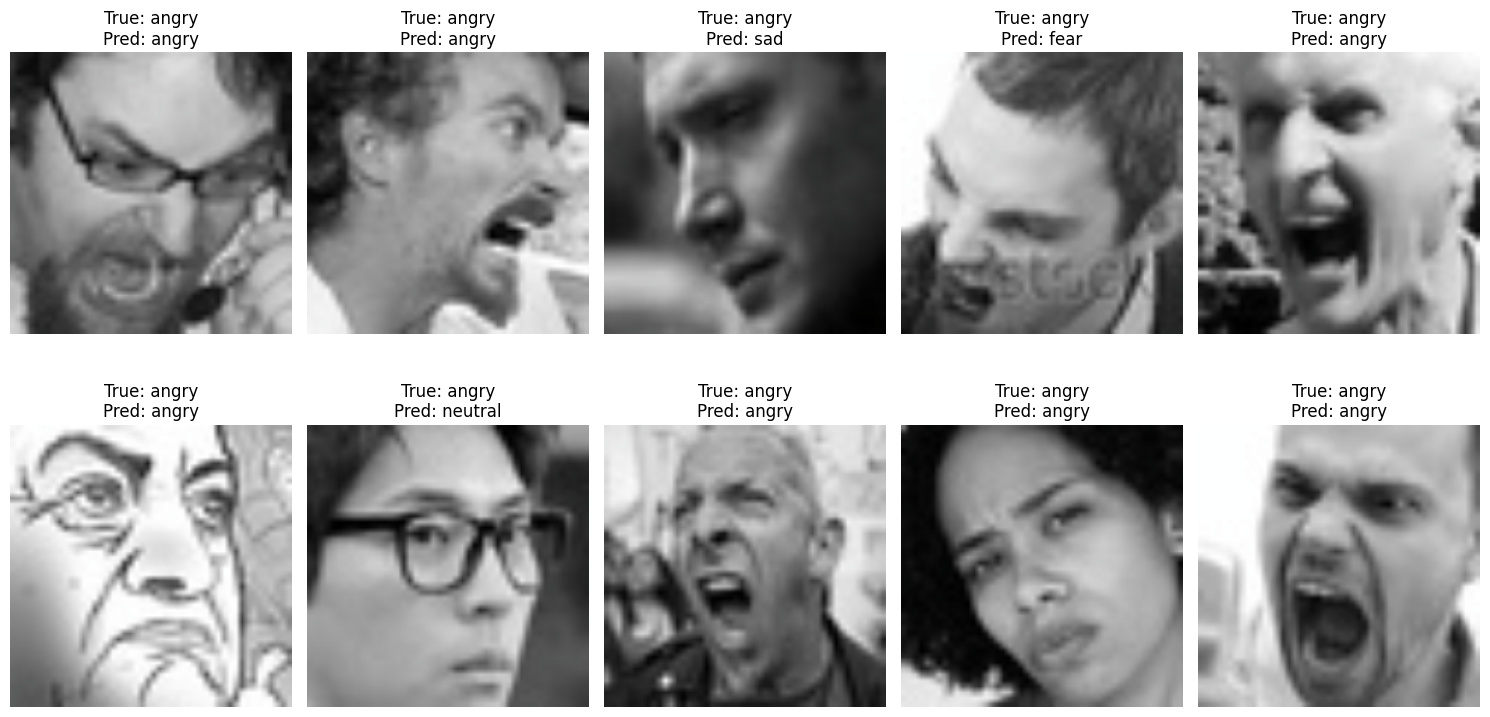

In [ ]:
show_predictions(model, test_loader, train_dataset.classes)